# 3. Simulating discrete stochastic processes 

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab, need to install multitaper')
  %pip install multitaper

from multitaper import mtspec

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## The problem with continuous white noise

Before we can go ahead and solve theoretically for the spectrum of
a Hasselmann model we need to deal with one more issue: How do we
set the variance of the stochastic forcing $F(t)$? One has to be
very careful when modeling discretized stochastic processes as the
amount of variance may change when changing the time-step and the
length of the time interval considered. The problem is that there
is no well-defined continuous version of a white noise process.
Parseval's theorem illustrates the issue: if a white noise process
$F(t)$ has a constant spectral density $\tilde{s}_{F}^{2}$, its variance would become infinite. 

$$
var(F)=\int_{-\infty}^{\infty}\tilde{s}_{F}^{2}df=\tilde{s}_{F}^{2}\int_{-\infty}^{\infty}df=\infty
$$

In reality white noise is not truly white at all frequencies. i.e.
it does not have a constant spectral density at all frequency. At
high enough frequency, the spectrum of the forcing does go down. This
is indeed Hasselmann's assumption; that the forcing is white at time-scales
longer than a given timescale $\tau_{w}$ (i.e. frequencies lower
than a frequency $f_{w}$). For example, if we were to assume weather
forcing $F$ was 'white' up to hourly time-scales it would mean
that weather is not correlated between this hour and the next hour.
In reality, weather is only uncorrelated (or, `white') at timescales
longer than $\sim 2$ weeks. 

**Side note:** White noise can informally defined as the time-derivative
of a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process) $F=dW/dt$, but I've been told that is not something mathematicians look kindly upon. If we want to stay in the time-domain, one option is to model the Hasselmann equation as an [Ornstein–Uhlenbeck Process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process): 

$$
dT=\tau_{0}^{-1}Tdt+\lambda^{-1}dW(t)
$$

where the ill-defined $Fdt$ is replaced by the well defined Wiener
process $dW$, a continuous version of the random walk. The problem
is that once we move passed the simple one-dimensional Hasselmann
model into more complex linear systems with more than one state variable
and more than one forcing, things become messy. Also, it may be the
case that the forcing term cannot be assumed to be white, which is
the case in the tropics.



## Nyquist frequency and a truncated white noise spectrum:

For a dataset sampled discretely at time intervals $\Delta t$ (which
is every dataset that we can measure or simulate) Nyquist-Snannon sampling theorem
tells us that we can only estimate the spectrum between frequencies $-f_{N}$ and $f_{N}$ where the Nyquist frequncy is

$$
f_{N}=\frac{1}{2\Delta t}. 
$$

More than that, the sampling theorem tells us that if there is spectral
power at frequencies $\left|f\right|>f_{N}$ than this power will be aliased at frequencies smaller than the sampling frequency $\left|f\right|<f_{N}$ and thus bias our estimate of the variance in this range. 

Thus, the preferred option for simulating a Hasselmann model is to
fix the spectral density of the forcing $F(t)$, and assume it is
zero outside the Nyquist frequency $f_{N}$.

$$
S_{FF}\left(f\right)=\begin{cases}
\tilde{s}_{F}^{2} & \text{if }f\in\left[-f_{N};f_{N}\right]\\
0 & \text{otherwise}
\end{cases}
$$

This both helps avoid the aliasing issue and also accounts for the
fact that Forcing spectrum is not truly white up to infinitely high
frequency. In this case, the variance of the discrete time-series
$F_{n}=F(t_{n})$ can be reconstructed as:

$$
\text{var}\left(F\right)=\sigma_{F}^{2}=C_{FF}\left(0\right)=\int_{-\infty}^{\infty}S_{FF}(f)df=\int_{-f_{N}}^{f_{N}}\tilde{s}_{F}^{2}df=\tilde{s}_{F}^{2}\cdot2f_{N}=\tilde{s}_{F}^{2}\cdot2\frac{1}{2\Delta t}
$$

$$
\boxed{\sigma_{F}^{2}=\frac{\tilde{s}_{F}^{2}}{\Delta t}}
$$


## Setting the variance in a simulation: Fixing spetral density $\tilde s_F$

When simulating a Hasselmann model discretely, we need to set the
variance of the discretized forcing vector $F_{n}$.

***IF*** we want the
process to have the same process spectra regardless of sampling interval
or length, we need to to rescale the variance we impose on $F_{n}$
by $1/\Delta t$. In practice, that means that we would fix
a value for $\tilde{s}_{F}$ and then draw a random vector $F_{n}$
that has standard deviation $\sigma_{F}=\tilde{s}_{F}/\sqrt{\Delta t}$.
This way, the spectral quantities that we try to estimate, such as the power-spectral density of $F$ and temperature $T$, do not depend
on our choice of numerical discretization. 

The figure below shows three simulations of a white noise process with the same *process* variance density $\tilde s_F^2=1$. Note that because we are only simulating a short interval the estimated spectral density of the sample varies around 1. Also note that we are only plotting positive frequencies. 

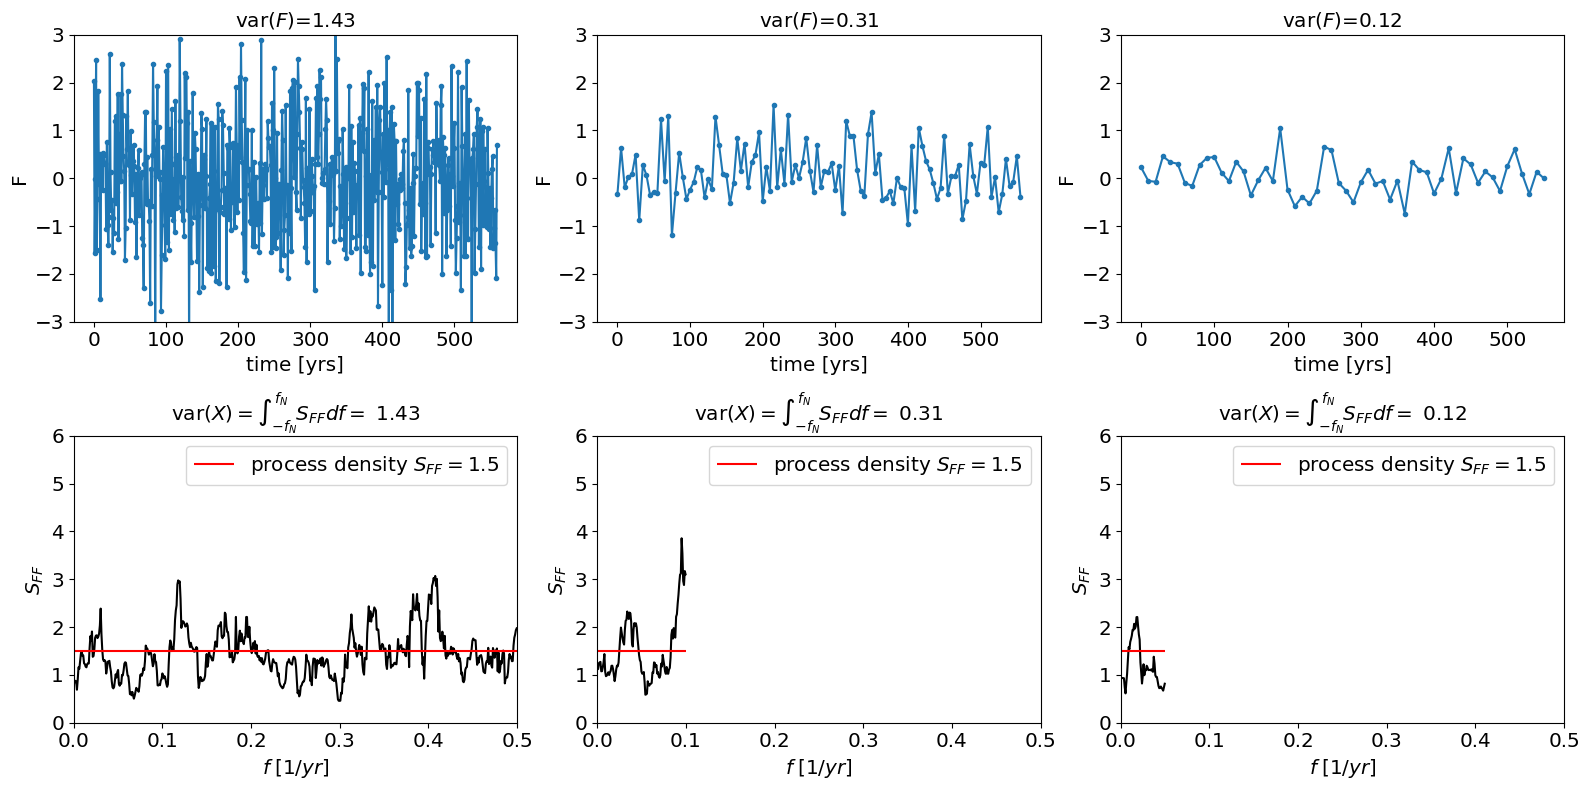

In [69]:
## 

# Fix the Spectral Variance Density sf^2
specdens=1.5;

# A vector of three different sampling intervals
dt_vec=[1,5,10]

# Total Simulation time
T_total=7*4*20;

#set up figure
plt.subplots(2,3,figsize=[16,8])

for i_dt in range(3):
    
    #sampling interval
    dt=dt_vec[i_dt]
    #time vector
    t=np.arange(0,T_total,dt)
    
    #total number of points:
    N=int(T_total/dt);

    # normalize density of F by \sqrt(dt). Not that spec
    var_F=specdens/dt
    sigma_F=np.sqrt(var_F)
    
    #simulate a white noise process:
    F=stats.norm.rvs(loc=0,scale=sigma_F,size=N);

    #compute the spectrum
    out=mtspec.MTSpec(F,nw=4,dt=dt,kspec=0,iadapt=0)
    freq=out.freq
    S_FF =out.spec
    S_FF=S_FF[freq>=0]
    freq=freq[freq>=0]
    
    plt.subplot(2,3,i_dt+1)
    plt.plot(t,F,'.-')
    
    plt.title(r'var$(F)$='+str(round(np.var(F),2)))
    plt.xlabel('time [yrs]')
    plt.ylabel('F')
    plt.ylim(-3,3)
    

    plt.subplot(2,3,i_dt+4)
    plt.plot(freq,S_FF,'k')
    plt.hlines(specdens,0,np.max(freq),color='r',label=r'process density $S_{FF}=$'+str(specdens))
    
    plt.title(r'var$(X)=\int_{-f_N}^{f_N} S_{FF}df=$ '+str(round(np.var(F),2)))
    plt.ylabel(r'$S_{FF}$')
    plt.xlabel(r'$f\; [1/yr]$')
    plt.ylim(0,6)
    plt.xlim(0,0.5)
    plt.legend()

plt.tight_layout()

## Alternatives

There are a few other alternatives for setting the variance of $F_n$. 

### Fixing $\sigma_{F}$ ($\Delta t$ is sampling time)

A second option for simulating a Hasselmann model is to set $\sigma_{F}$,
i.e the variance of the time-domain vector $F(t_{n})$. This might
seem the easiest approach, since $\sigma_{F}$ is what we actually
provide python when drawing samples from a random vector. However,
in this scenario, the spectral density of $F$ will change if we change
$\Delta t$. 

A scenario where a white noise process has the same variance regardless
of time-step is (more-or-less) equivalent to plucking data points
at a time-step $\Delta t$. For example, if we compare a dataset with
$\Delta t=1$ day and one with $\Delta t=1$ month and they have the
same variance, this is as if the data that is collected every month
is actually just daily data collected only day per month. 

In this case, the power spectral density we would estimate for $F$
is $\hat{\tilde{s}}_{F}^{2}=\sigma_{F}^{2}\Delta t$. So as we increase
the time-step, we would get higher spectral densities. This increase in power spectral density can be interpretated as arising from the fact that the spectral power at frequencies higher than the highest accessible frequency $f_{N}$ is getting aliased back into our spectral estimate between $-f_{N}$ and $f_{N}$

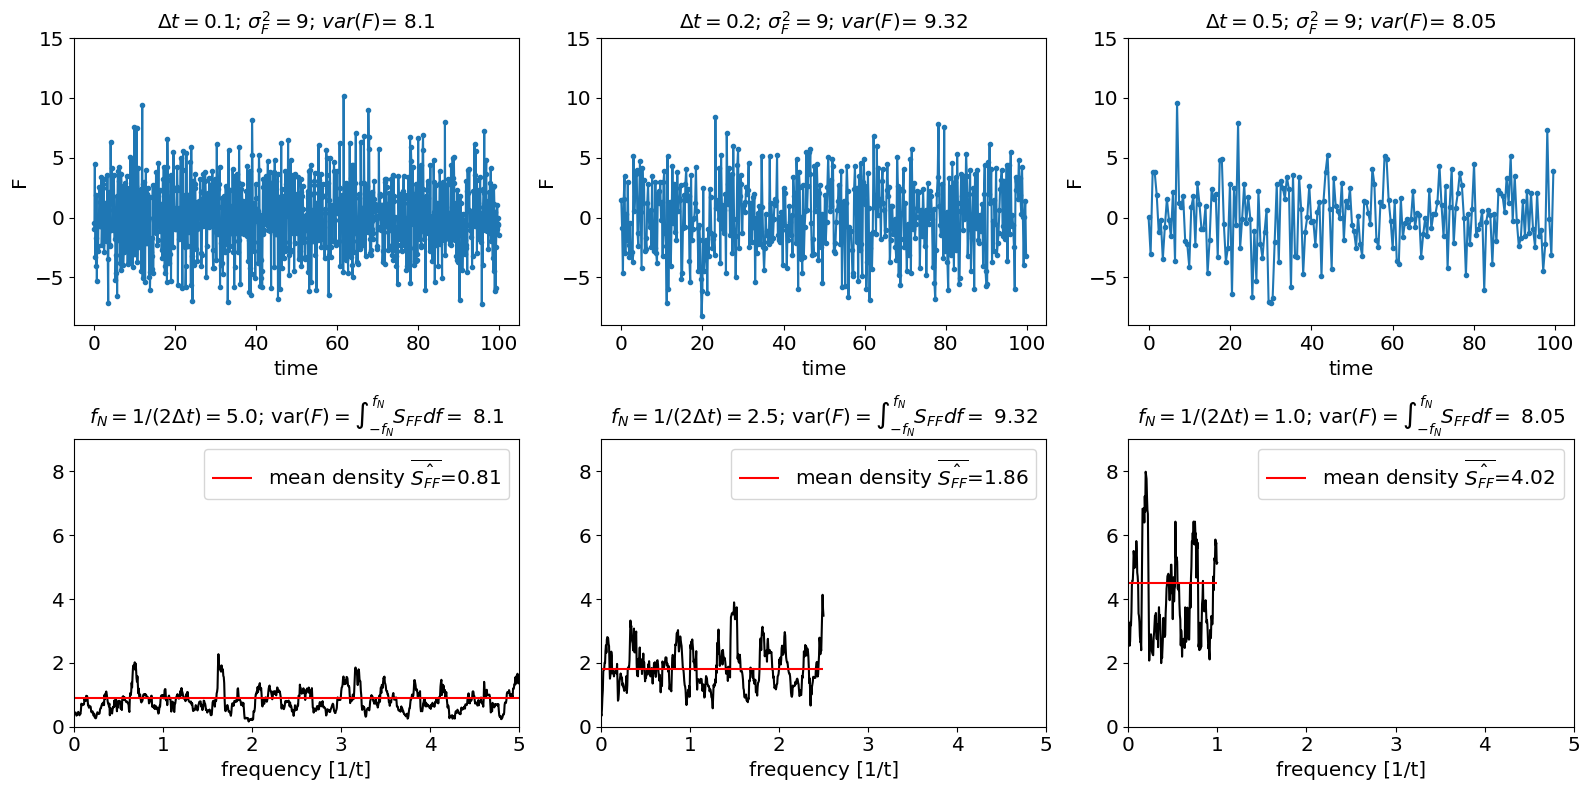

In [113]:
# A vector of three different sampling intervals
dt_vec=[0.1,0.2,0.5]

# Total Simulation time
T_total=100;


#standard deviation sigma_f of the discrete white noise proces 
# var(F) = sigma_F^2
sigma_F=3;


#set up figure
plt.figure(figsize=[16,8])

for i_dt in range(3):
    
    #sampling interval
    dt=dt_vec[i_dt]
    #time vector
    t=np.arange(0,T_total,dt)
    
    #total number of points:
    N=int(T_total/dt);

    #simulate a white noise process:
    F=stats.norm.rvs(loc=0,scale=sigma_F,size=N);

    #compute the spectrum
    out=mtspec.MTSpec(F,nw=4,dt=dt,kspec=0)
    freq=out.freq
    S_FF =out.spec
    S_FF=S_FF[freq>=0]
    freq=freq[freq>=0]
    
    plt.subplot(2,3,i_dt+1)
    plt.plot(t,F,'.-')
    plt.title(r'$\Delta t=$'+str(dt)+r'; $\sigma_F^2=$'+str(round(sigma_F**2))+'; $var(F)$= '+str(round(np.var(F),2)))
    plt.ylim(-9,15)
    plt.xlabel('time')
    plt.ylabel('F')

    plt.subplot(2,3,i_dt+3+1)
    plt.plot(freq,S_FF,'k')
    plt.hlines(sigma_x**2*dt,0,np.max(freq),color='r',label=r'mean density $\overline{\hat{S_{FF}}}$='+str(round(np.mean(S_FF),2)))
    plt.title(r'$f_N=1/(2\Delta t)=$'+str(round(np.max(freq),2))+r'; var$(F)=\int_{-f_N}^{f_N} S_{FF}df=$ '+str(round(np.var(F),2)))
    plt.ylim(0,9)
    plt.xlim(0,5)
    plt.xlabel('frequency [1/t]');
    plt.legend()
plt.tight_layout()


### Small $\Delta t$ then averaging

A third, more realistic approach would be to use to different timescales
to simulate the fact that we are taking discrete averages of a continuous
process. We would first choose a very small numerical time-step $\Delta t_{num}$
at which to discretize the continuous Hasselmann equation, and assume
that the forcing spectrum is zero at frequencies higher than $f=1/\left(2\Delta t_{N}\right).$
We would then take block averages of larger $\Delta t$ intervals

Below I simulate a model using a numerical time-step of $\Delta t_{num}=1$ meant to represent, for example, using a daily resolution, then take averages of $\Delta t=7$ days and $\Delta t=28$ days to represent using weekly or monthly averaged data. 

Notice that this scenario ends up being very similar to the first proposed way, of assuming the spectral density $S_FF$ is zero at frequencies higher than the Nyquist frequency. This is because time-averaging is a form of a low-pass filter. In fact, moving average and sampling imparts a slightly different spectrum than a pure low-pass filter that sets all spectral power to zero above $1/(2\Delta t)$ and keeps them the same at lower frequencies. But the details of low-pass filtering go beyond the scope of these notes. 

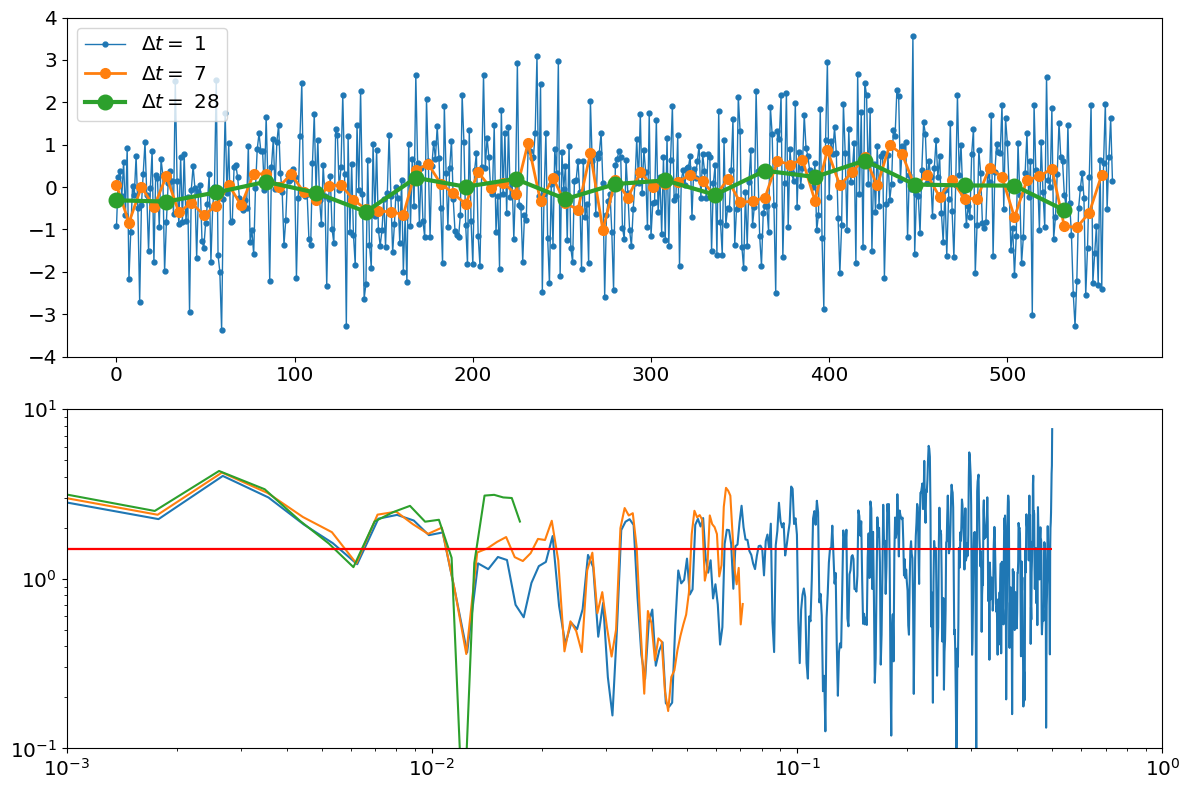

In [112]:
# Spectral density
specdens=1.5;

# original sampling interval (time-step)
dt_num=1

# Total Simulation time
T_total=7*4*20;

N=int(T_total/dt_num);

# A vector of three different sampling intervals
dt_vec=[1,7,7*4]

#set up figure
plt.subplots(2,1,figsize=[12,8])

#simulate one process
var_F=specdens/dt_orig
sigma_F=np.sqrt(var_F);
F_orig=stats.norm.rvs(loc=0,scale=sigma_F,size=N);


for i_dt in range(3):
    
    #take averages of lenth dt
    dt=dt_vec[i_dt]

    #how many samples go in an average?
    dn=dt/dt_orig
    
    #locs=np.arange(0,N,dn).astype('int')
    #coarse time vector
    t=np.arange(0,T_total,dt_vec[i_dt])
    
    #take block averages
    F=np.reshape(F_orig,[int(N/dn),int(dn)]).mean(axis=1); 

    #compute the spectrum
    out=mtspec.MTSpec(F,nw=1.5,dt=dt,kspec=0,iadapt=0)
    freq=out.freq
    S_FF=out.spec
    S_FF=S_FF[freq>=0]
    freq=freq[freq>=0]
    
    plt.subplot(2,1,1)
    plt.plot(t,F,'.-',linewidth=i_dt+1,markersize=7*(i_dt+1),label=r'$\Delta t=$ '+str(dt))
    plt.ylim(-4,4)
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(freq,S_FF)
    plt.hlines(specdens,0,np.max(freq),color='r',label=r'process $S_{ff}$')
    plt.ylim(1E-1,1E1)
    plt.xlim(1E-3,1)
    plt.yscale('log')
    plt.xscale('log')
plt.tight_layout()